In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision

import time
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from torchsummary import summary

from di_dataset3 import DepthImageDataset, collate_batch
from torch.utils.tensorboard import SummaryWriter

In [21]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Hyperparams

In [22]:
LINUX = False

latent_dim = 64
num_epochs = 500
batch_size = 32
learning_rate = 1e-3

save_model = True
load_model = True

if LINUX:
    base_path = "/home/patricknit"
else:
    base_path = "/Users/patricknitschke/Library/CloudStorage/OneDrive-NTNU/NTNU/Kybernetikk og robotikk/Master/Thesis/Code"

tfrecord_folder = base_path + "/rl_data/tfrecord_wfiltered"
tfrecord_test_folder = tfrecord_folder

save_model_file = base_path + "/vae_models/vae_resnet_MSE_weighted_x10_avg_pool_interpolate.pth"
load_model_file = base_path + "/vae_models/vae_resnet_MSE_weighted_x10_avg_pool_interpolate.pth_60.pth"

writer = SummaryWriter('runs'+save_model_file[save_model_file.rfind("/"):])
    

# Load Dataset

In [23]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size, one_tfrecord=True) # 180 tfrecords
test_dataset = DepthImageDataset(tfrecord_folder=tfrecord_test_folder, batch_size=batch_size, one_tfrecord=True) # 20 tfrecords

len_train_dataset = len(train_dataset)
len_test_dataset = len(test_dataset)
n_training_samples = len_train_dataset * 32 # 32 samples per batch
print(len_train_dataset, len_test_dataset)

train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, collate_fn=collate_batch)

Loading tfrecords... 	Iterating length... 	Done: 73
Loading tfrecords... 	Iterating length... 	Done: 65


In [26]:
dataiter = iter(train_loader)
images, images_filtered, *_ = dataiter.next() # image, filtered image, height, width, depth
images.shape, images_filtered.shape

gotcha


(torch.Size([32, 1, 270, 480]), torch.Size([32, 1, 270, 480]))

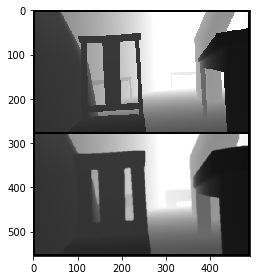

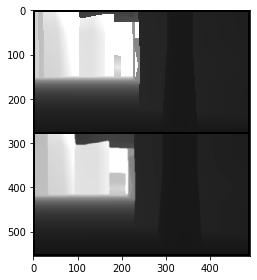

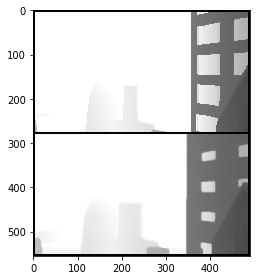

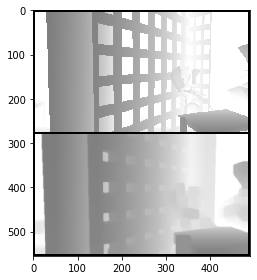

In [27]:
def imshow(image):
    io.imshow(image.squeeze().numpy())
    io.show()

def make_grid_for_tensorboard(images_list, n_grids=2):
    joined_images = []
    [joined_images.extend(images[:n_grids]) for images in images_list]
    return torchvision.utils.make_grid(joined_images, nrow=1, padding=5)

def gridshow(images_list, n_grids=None):
    for n, items in enumerate(zip(*images_list)):
        grid = torchvision.utils.make_grid([*items], nrow=1, padding=5).permute(1, 2, 0)
        imshow(grid)
        if (n+1) == n_grids:
            return

gridshow([images, images_filtered], n_grids=4)
#imshow(make_grid_for_tensorboard([images, images_filtered]).permute(1,2,0))

# Define Variational Autoencoder

Adapted from https://github.com/microsoft/AirSim-Drone-Racing-VAE-Imitation/blob/master/racing_models/cmvae.py

### Dronet
ResNet8 as encoder.

In [28]:
def xavier_uniform_init(m):
    """
    Default initialisation in Keras is glorot_uniform == xavier_uniform in Pytorch

    https://discuss.pytorch.org/t/crossentropyloss-expected-object-of-type-torch-longtensor/28683/6?u=ptrblck
    https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    """
    assert isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d)
    nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('linear')) # gain=nn.init.calculate_gain('relu')
    nn.init.zeros_(m.bias)
    
    return m

In [29]:
class Lambda(nn.Module):
    def __init__(self, func):
        super(Lambda, self).__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)

class Add(nn.Module):
    def __init__(self):
        super(Add, self).__init__()
        
    def forward(self, x1, x2):
        return x1 + x2

In [30]:
class AdaptiveAvgPool2d(nn.Module):
    def __init__(self, output_size):
        super(AdaptiveAvgPool2d, self).__init__()
        self.adaptive_avg_pool2d = F.adaptive_avg_pool2d
        self.out_size = output_size
        
    def forward(self, x):
        x = self.adaptive_avg_pool2d(x, output_size=self.out_size)
        return x
    
class Dronet(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(Dronet, self).__init__()
        self.latent_dim = latent_dim
        self.n_channels = input_size[0]
        self.add = Add()
        # self.p = 0
        
        # Bottom layers
        self.conv_0 = nn.Conv2d(self.n_channels, 32, kernel_size=5, stride=2, padding=2)
        xavier_uniform_init(self.conv_0)
        self.max_pool_0 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        
        
        # Layers for first residual block
        self.batch_norm_0 = nn.BatchNorm2d(32)
        self.activation_0 = nn.ReLU()
        # self.dropout_0 = MonteCarloDropout(self.p)
        self.conv_1 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
        
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.activation_1 = nn.ReLU()
        # self.dropout_1 = MonteCarloDropout(self.p)
        self.conv_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        
        self.conv_3 = nn.Conv2d(32, 32, kernel_size=1, stride=2)
        xavier_uniform_init(self.conv_3)
        # add
        

        # Layers for second residual block
        self.batch_norm_2 = nn.BatchNorm2d(32)
        self.activation_2 = nn.ReLU()
        # self.dropout_2 = MonteCarloDropout(self.p)
        self.conv_4 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        
        self.batch_norm_3 = nn.BatchNorm2d(64)
        self.activation_3 = nn.ReLU()
        # self.dropout_3 = MonteCarloDropout(self.p)
        self.conv_5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv_6 = nn.Conv2d(32, 64, kernel_size=1, stride=2)
        xavier_uniform_init(self.conv_6)
        #add
        

        # Layers for third residual block
        self.batch_norm_4 = nn.BatchNorm2d(64)
        self.activation_4 = nn.ReLU()
        # self.dropout_4 = MonteCarloDropout(self.p)
        self.conv_7 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        self.batch_norm_5 = nn.BatchNorm2d(128)
        self.activation_5 = nn.ReLU()
        # self.dropout_5 = MonteCarloDropout(self.p)
        self.conv_8 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv_9 = nn.Conv2d(64, 128, kernel_size=1, stride=2)
        xavier_uniform_init(self.conv_9)
        #add


        # Top layers
        self.avg_pool_1 = AdaptiveAvgPool2d(output_size=(6,10)) # TODO: padding = same??
        self.flatten = nn.Flatten()
        self.activation_6 = nn.ReLU()
        # self.dropout_6 = MonteCarloDropout(self.p)
        
        self.latent_space = nn.Linear(6*10*128, 2*self.latent_dim)
        

    def forward(self, x):
        # Bottom layers
        x1 = self.conv_0(x)
        x1 = self.max_pool_0(x1)
        

        # First residual block
        x2 = self.batch_norm_0(x1)
        x2 = self.activation_0(x2)
        # x2 = self.dropout_0(x2)
        x2 = self.conv_1(x2)
        
        x2 = self.batch_norm_1(x2)
        x2 = self.activation_1(x2)
        # x2 = self.dropout_1(x2)
        x2 = self.conv_2(x2)
        
        x1 = self.conv_3(x1)
        x3 = self.add(x1, x2) # 34,60
        

        # Second residual block
        x4 = self.batch_norm_2(x3)        
        x4 = self.activation_2(x4)
        # x4 = self.dropout_2(x4)
        x4 = self.conv_4(x4)
        
        x4 = self.batch_norm_3(x4)
        x4 = self.activation_3(x4)
        # x4 = self.dropout_3(x4)
        x4 = self.conv_5(x4)
        
        x3 = self.conv_6(x3)
        x5 = self.add(x3, x4)
        

        # Third residual block
        x6 = self.batch_norm_4(x5)
        x6 = self.activation_4(x6)
        # x6 = self.dropout_4(x6)
        x6 = self.conv_7(x6)
        
        x6 = self.batch_norm_5(x6)
        x6 = self.activation_5(x6)
        # x6 = self.dropout_5(x6)
        x6 = self.conv_8(x6)
        
        x5 = self.conv_9(x5)
        x7 = self.add(x5, x6)
        

        # Top layers
        x7 = self.avg_pool_1(x7)
        x = self.flatten(x7)
        x = self.activation_6(x)
        # x = self.dropout_6(x)
        x = self.latent_space(x)
        
        return x
    
dronet = Dronet(input_size=(1, 270, 480), latent_dim=latent_dim)
summary(dronet, input_size=(1, 270, 480), batch_size=-1, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 135, 240]             832
         MaxPool2d-2          [-1, 32, 67, 120]               0
       BatchNorm2d-3          [-1, 32, 67, 120]              64
              ReLU-4          [-1, 32, 67, 120]               0
            Conv2d-5           [-1, 32, 34, 60]           9,248
       BatchNorm2d-6           [-1, 32, 34, 60]              64
              ReLU-7           [-1, 32, 34, 60]               0
            Conv2d-8           [-1, 32, 34, 60]           9,248
            Conv2d-9           [-1, 32, 34, 60]           1,056
              Add-10           [-1, 32, 34, 60]               0
      BatchNorm2d-11           [-1, 32, 34, 60]              64
             ReLU-12           [-1, 32, 34, 60]               0
           Conv2d-13           [-1, 64, 17, 30]          18,496
      BatchNorm2d-14           [-1, 64,

### Decoder

In [31]:
class Interpolate(nn.Module):
    def __init__(self, size, mode):
        super(Interpolate, self).__init__()
        self.interp = F.interpolate
        self.size = size
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, size=self.size, mode=self.mode)
        return x

class ImgDecoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(ImgDecoder, self).__init__()
        print('[ImgDecoder] Starting create_model')
        self.latent_dim = latent_dim
        self.n_channels = input_size[0]
        self.add = Add()
        #self.p = 0
        
        # Top layers
        self.latent_space = nn.Linear(latent_dim, 6*10*128)
        self.activation_6 = nn.ReLU()
        # self.dropout_5 = MonteCarloDropout(self.p)
        self.unflatten = nn.Unflatten(dim=-1, unflattened_size=(128, 6, 10))
        self.interpolate_1 = Interpolate(size=(9, 15), mode="nearest")
        
        # From pytorch docs: 
        # *output_padding* is only used to find output shape, but does not actually add zero-padding to output.

        # Layers for third residual block
        self.batch_norm_4 = nn.BatchNorm2d(128)
        self.activation_4 = nn.ReLU()
        # self.dropout_4 = MonteCarloDropout(self.p)
        self.convT_7 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(0,1)) 

        self.batch_norm_5 = nn.BatchNorm2d(64)
        self.activation_5 = nn.ReLU()
        # self.dropout_5 = MonteCarloDropout(self.p)
        self.convT_8 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1) 

        self.convT_9 = nn.ConvTranspose2d(128, 64, kernel_size=1, stride=2, output_padding=(0,1))
        xavier_uniform_init(self.convT_9)


        # Layers for second residual block
        self.batch_norm_2 = nn.BatchNorm2d(64)
        self.activation_2 = nn.ReLU()
        # self.dropout_2 = MonteCarloDropout(self.p)
        self.convT_4 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1,1)) 
        
        self.batch_norm_3 = nn.BatchNorm2d(32)
        self.activation_3 = nn.ReLU()
        # self.dropout_3 = MonteCarloDropout(self.p)
        self.convT_5 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1) 

        self.convT_6 = nn.ConvTranspose2d(64, 32, kernel_size=1, stride=2, output_padding=(1,1))
        xavier_uniform_init(self.convT_6)
        #add

        
        # Layers for first residual block
        self.batch_norm_0 = nn.BatchNorm2d(32)
        self.activation_0 = nn.ReLU()
        # self.dropout_0 = MonteCarloDropout(self.p)
        self.convT_1 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=(0,1)) # 
        
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.activation_1 = nn.ReLU()
        # self.dropout_1 = MonteCarloDropout(self.p)
        self.convT_2 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1) # padding='same' 
        
        self.convT_3 = nn.ConvTranspose2d(32, 32, kernel_size=1, stride=2, output_padding=(0,1))
        xavier_uniform_init(self.convT_3)
        # add


        # Bottom layers
        self.upsampling_0 = nn.Upsample(size=(135,240), mode="nearest")
        self.convT_0 = nn.ConvTranspose2d(32, self.n_channels, kernel_size=5, stride=2, padding=2, output_padding=(1,1))
        xavier_uniform_init(self.convT_0)

        
    def forward(self, z):
        # Bottom layers
        x = self.latent_space(z)
        x = self.activation_6(x)
        # x = self.dropout_6(x)
        x7 = self.unflatten(x)
        x7 = x7.squeeze()
        x7 = self.interpolate_1(x7)


        # Third residual block
        x6 = self.batch_norm_4(x7)
        x6 = self.activation_4(x6)
        # x6 = self.dropout_4(x6)
        x6 = self.convT_7(x6)
        
        x6 = self.batch_norm_5(x6)
        x6 = self.activation_5(x6)
        # x6 = self.dropout_5(x6)
        x6 = self.convT_8(x6)
        
        x7 = self.convT_9(x7)
        x5= self.add(x6, x7)


        # Second residual block
        x4 = self.batch_norm_2(x5)        
        x4 = self.activation_2(x4)
        # x4 = self.dropout_2(x4)
        x4 = self.convT_4(x4)
        
        x4 = self.batch_norm_3(x4)
        x4 = self.activation_3(x4)
        # x4 = self.dropout_3(x4)
        x4 = self.convT_5(x4)
        
        x5 = self.convT_6(x5)
        x3 = self.add(x4, x5)


        # First residual block
        x2 = self.batch_norm_0(x3)
        x2 = self.activation_0(x2)
        # x2 = self.dropout_0(x2)
        x2 = self.convT_1(x2)
        
        x2 = self.batch_norm_1(x2)
        x2 = self.activation_1(x2)
        # x2 = self.dropout_1(x2)
        x2 = self.convT_2(x2)
        
        x3 = self.convT_3(x3)
        x1 = self.add(x2, x3)

        # Bottom layers
        x1 = self.upsampling_0(x1)      # (32, 135, 240)
        x = self.convT_0(x1)            # (1, 270, 480)
        x = torch.sigmoid(x)
        return x
        

img_decoder = ImgDecoder(input_size=(1, 270, 480), latent_dim=latent_dim)
summary(img_decoder, input_size=(1,latent_dim))

[ImgDecoder] Starting create_model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 7680]         499,200
              ReLU-2              [-1, 1, 7680]               0
         Unflatten-3        [-1, 1, 128, 6, 10]               0
       Interpolate-4           [-1, 128, 9, 15]               0
       BatchNorm2d-5           [-1, 128, 9, 15]             256
              ReLU-6           [-1, 128, 9, 15]               0
   ConvTranspose2d-7           [-1, 64, 17, 30]          73,792
       BatchNorm2d-8           [-1, 64, 17, 30]             128
              ReLU-9           [-1, 64, 17, 30]               0
  ConvTranspose2d-10           [-1, 64, 17, 30]          36,928
  ConvTranspose2d-11           [-1, 64, 17, 30]           8,256
              Add-12           [-1, 64, 17, 30]               0
      BatchNorm2d-13           [-1, 64, 17, 30]             128
    

## VAE

In [32]:

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        
        # create the 3 base models:
        self.q_img = Dronet(input_dim, latent_dim)
        self.p_img = ImgDecoder(input_dim, latent_dim)
        
        # Create sampler
        self.mean_params = Lambda(lambda x: x[:, :latent_dim])
        self.logvar_params = Lambda(lambda x: x[:, latent_dim:])

    def forward(self, x):
        # Possible modes for reconstruction:
        # img -> img

        x = self.q_img(x)
        
        means = self.mean_params(x)
        logvar = self.logvar_params(x)
        stddev = torch.exp(0.5 * logvar)
        eps = torch.randn_like(stddev)
        z = means + eps * stddev
        img_recon = self.p_img(z)
        
        return img_recon, means, logvar, z
    
    def forward_test(self, x):
        x = self.q_img(x)
        
        means = self.mean_params(x)
        logvar = self.logvar_params(x)
        stddev = torch.exp(0.5 * logvar)
        eps = torch.zeros_like(stddev)
        z = means + eps * stddev
        img_recon = self.p_img(z)
        
        return img_recon, means, logvar, z
        

    def encode(self, x):
        x = self.q_img(x)
        means = self.mean_params(x)
        stddev = torch.exp(0.5 * self.stddev_params(x))
        eps = torch.randn_like(stddev)
        z = means + eps * stddev
        return z, means, stddev

    def decode(self, z):
        # Possible modes for reconstruction:
        # z -> img
        img_recon = self.p_img(z)
        return img_recon


### Define Model

In [33]:
vae_model = VAE(input_dim=(1, 270, 480), latent_dim=latent_dim)
#writer.add_graph(vae_model, images)

if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))
    print(f"Loaded model: {load_model_file}")

optimiser = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
summary(vae_model, (1, 270, 480))

[ImgDecoder] Starting create_model
Loaded model: /Users/patricknitschke/Library/CloudStorage/OneDrive-NTNU/NTNU/Kybernetikk og robotikk/Master/Thesis/Code/vae_models/vae_resnet_MSE_weighted_x10_avg_pool_interpolate.pth_60.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 135, 240]             832
         MaxPool2d-2          [-1, 32, 67, 120]               0
       BatchNorm2d-3          [-1, 32, 67, 120]              64
              ReLU-4          [-1, 32, 67, 120]               0
            Conv2d-5           [-1, 32, 34, 60]           9,248
       BatchNorm2d-6           [-1, 32, 34, 60]              64
              ReLU-7           [-1, 32, 34, 60]               0
            Conv2d-8           [-1, 32, 34, 60]           9,248
            Conv2d-9           [-1, 32, 34, 60]           1,056
              Add-10           [-1, 32, 34, 60]               0
     

# Training

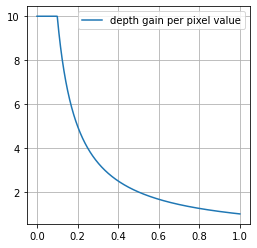

In [34]:
def depth_gain(x):
    return np.minimum(1/(x+0.0001), 10*np.ones_like(x))

x = np.arange(0, 1.001, 0.001)
y = depth_gain(x)

plt.figure(figsize=(4, 4))
plt.plot(x, y)
plt.grid()
plt.legend(["depth gain per pixel value"])
plt.show()

In [35]:
def BCELoss(x, x_hat, mean, log_var):
    reproduction_loss = nn.BCELoss(reduction='mean')(x_hat, x) * (270 * 480)
    KLD      = 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss - KLD

def MSE(x, x_hat, mu, logvar):
    #rep = (x_hat - x)**2
    reproduction_loss = F.mse_loss(x_hat, x, reduction="mean") * (270 * 480)
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss - kl_divergence

def weighted_MSE(x, x_hat, mu, logvar):    
    reproduction_loss = (depth_gain(x) * torch.square(x_hat - x)).sum()
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reproduction_loss - kl_divergence

def filtered_weighted_MSE(filtered_x, x_hat, mu, logvar): 
    reproduction_loss = (depth_gain(filtered_x) * torch.square(x_hat - filtered_x)).mean() * (270 * 480)
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reproduction_loss - kl_divergence

In [36]:
time_iteration = []
# train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
# train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
# train_loader = next(iter(train_loader))

if load_model:
    start = load_model_file.rfind("_") + 1
    end = load_model_file.rfind(".")
    epoch_start = int("".join([char for char in load_model_file[start:end]]))
    num_epochs = [epoch_start, num_epochs]
else:
    num_epochs = [num_epochs]

for epoch in range(*num_epochs):
    running_loss = 0
    overall_elbo = 0
    since = time.time()
    
    # Random file each time
    train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size, one_tfrecord=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
    n_iterations = len(train_loader)
    
    for i, (image, image_filtered, *_) in enumerate(train_loader):
        since_iter = time.time()

        optimiser.zero_grad()

        # VAE forward pass
        x_hat, mu, logvar, z = vae_model(image)

        # Loss
        loss = filtered_weighted_MSE(image_filtered, x_hat, mu, logvar)
        running_loss += loss

        # Update weights
        loss.backward()
        optimiser.step()
        
        
        time_iteration.append(time.time() - since_iter)
        iter_time_mean = np.array(time_iteration).mean()
        
        # Log info
        writer.add_scalar('training loss', running_loss/((i+1)*batch_size), global_step=epoch*n_iterations + i + 1)
        if (i+1) % (5) == 0:
            time_elapsed = time.time() - since
            print(f"Epoch: {epoch+1}/{num_epochs[-1]}, Step: {i+1}/{n_iterations}, Avg loss: {running_loss/((i+1)*batch_size):.3f}",\
                f"time: {time_elapsed:.2f}, Avg. per iter {iter_time_mean:.2f}, Est. time left {iter_time_mean*(n_iterations - (i+1)):.2f}")
            
        if (i+1) % 5 == 0:
            grid = make_grid_for_tensorboard([image, image_filtered, x_hat], n_grids=1)
            writer.add_image('training images', grid, global_step=epoch*n_iterations + i + 1)
            
    if (epoch+1) % 10 == 0:
        save_model_file_dir = save_model_file + f"_{epoch+1}.pth"
        torch.save(vae_model.state_dict(), save_model_file_dir)
            

Loading tfrecords... 	Iterating length... 	Done: 60
gotcha
Epoch: 61/[60, 500], Step: 5/60, Avg loss: 146.599 time: 10.65, Avg. per iter 1.64, Est. time left 90.25
Epoch: 61/[60, 500], Step: 10/60, Avg loss: 148.388 time: 15.92, Avg. per iter 1.33, Est. time left 66.64
Epoch: 61/[60, 500], Step: 15/60, Avg loss: 139.404 time: 22.54, Avg. per iter 1.32, Est. time left 59.41
Epoch: 61/[60, 500], Step: 20/60, Avg loss: 134.312 time: 28.93, Avg. per iter 1.30, Est. time left 52.04
Epoch: 61/[60, 500], Step: 25/60, Avg loss: 132.428 time: 35.14, Avg. per iter 1.28, Est. time left 44.86
Epoch: 61/[60, 500], Step: 30/60, Avg loss: 128.246 time: 40.78, Avg. per iter 1.25, Est. time left 37.50
Epoch: 61/[60, 500], Step: 35/60, Avg loss: 125.592 time: 46.15, Avg. per iter 1.22, Est. time left 30.53
Epoch: 61/[60, 500], Step: 40/60, Avg loss: 123.966 time: 51.37, Avg. per iter 1.20, Est. time left 23.91
Epoch: 61/[60, 500], Step: 45/60, Avg loss: 123.131 time: 56.91, Avg. per iter 1.18, Est. time

KeyboardInterrupt: 

In [ ]:
load_model_file = base_path + "/vae_models/vae_resnet_MSE_weighted_470.pth"
load_model=False

if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))

# Evaluation

In [ ]:
vae_model.eval()

# Visualise sample of images
with torch.no_grad():
    images, filtered, *_ = next(iter(test_loader))
    x_hat, *_ = vae_model.forward_test(images)

    print(images.mean(), filtered.mean(), x_hat.mean())
    print(images.var(), filtered.var(), x_hat.var())

    gridshow([images, filtered, x_hat], n_grids=batch_size)

In [ ]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)

vae_model.eval()

with torch.no_grad():
    images, filtered, *_ = next(iter(train_loader))
    x_hat, *_ = vae_model.forward_test(images)

    print(images.mean(), filtered.mean(), x_hat.mean())
    print(images.var(), filtered.var(), x_hat.var())

    gridshow([images, filtered, x_hat], n_grids=batch_size)
